[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1972bNHN_BBTEorvLxqTvdRS4nC3PWj7O#scrollTo=jTQTcDbj9uxr)

### TMDB Box Office Prediction

**[1. Data loading and overview](#heading--1)**

**[2. Exploratory Data Analysis](#heading--2)**

  * [2.1. Checking missing values](#heading--2-1)
  * [2.2. belongs_to_collection column](#heading--2-2)
  * [2.3. genres column](#heading--2-3)
  * [2.4. production_companies column](#heading--2-4)
  * [2.5. production_countries column](#heading--2-5)
  * [2.6. spoken_languages column](#heading--2-6)
  * [2.7. Keywords column](#heading--2-7)
  * [2.8. Cast column](#heading--2-8)


In [120]:
import numpy as np
import pandas as pd
import ast
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import warnings
warnings.filterwarnings('ignore')


### 1. Data loading and overview <a name="heading--1"/>


In [121]:
# Loading train and test data
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')

# copying of original data
train = train_raw.copy()
test = test_raw.copy()

# Id from test set is necessary to submit the file on Kaggle
test_id = test['id']

# 'revenue' is the target variable
target = train['revenue']

In [122]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.5754,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.2489,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.3000,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.1749,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0000,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.1481,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0000,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [123]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.8515,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0000,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.5598,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.0852,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.5960,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,"[{'name': 'TS Productions', 'id': 313}, {'name...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0000,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.2177,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0000,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [124]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [125]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4398 non-null   int64  
 1   belongs_to_collection  877 non-null    object 
 2   budget                 4398 non-null   int64  
 3   genres                 4382 non-null   object 
 4   homepage               1420 non-null   object 
 5   imdb_id                4398 non-null   object 
 6   original_language      4398 non-null   object 
 7   original_title         4398 non-null   object 
 8   overview               4384 non-null   object 
 9   popularity             4398 non-null   float64
 10  poster_path            4397 non-null   object 
 11  production_companies   4140 non-null   object 
 12  production_countries   4296 non-null   object 
 13  release_date           4397 non-null   object 
 14  runtime                4394 non-null   float64
 15  spok

In [126]:
# some basic statistics for numerical columns
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3000.0000,1500.5000,866.1697,1.0000,750.7500,1500.5000,2250.2500,3000.0000
budget,3000.0000,22531334.1100,37026086.4120,0.0000,0.0000,8000000.0000,29000000.0000,380000000.0000
popularity,3000.0000,8.4633,12.1040,0.0000,4.0181,7.3749,10.8910,294.3370
runtime,2998.0000,107.8566,22.0864,0.0000,94.0000,104.0000,118.0000,338.0000
revenue,3000.0000,66725851.8887,137532326.3360,1.0000,2379808.2500,16807068.0000,68919203.5000,1519557910.0000


In [127]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4398.0000,5199.5000,1269.7376,3001.0000,4100.2500,5199.5000,6298.7500,7398.0000
budget,4398.0000,22649291.1173,36899910.8813,0.0000,0.0000,7450000.0000,28000000.0000,260000000.0000
popularity,4398.0000,8.5502,12.2090,0.0000,3.8952,7.4822,10.9385,547.4883
runtime,4394.0000,107.6222,21.0583,0.0000,94.0000,104.0000,118.0000,320.0000


In [128]:
# some basic statistics for object columns
train.describe(include=['object']).T

,count,unique,top,freq
belongs_to_collection,604,422,"[{'id': 645, 'name': 'James Bond Collection', ...",16
genres,2993,872,"[{'id': 18, 'name': 'Drama'}]",266
homepage,946,941,http://www.transformersmovie.com/,4
imdb_id,3000,3000,tt4085944,1
original_language,3000,36,en,2575
original_title,3000,2975,Sahara,2
overview,2992,2992,"Set after the events of Continental Drift, Scr...",1
poster_path,2999,2999,/vn4iLUhXYAtoVXgXeQ2L7fFZZBr.jpg,1
production_companies,2844,2383,"[{'name': 'Paramount Pictures', 'id': 4}]",51
production_countries,2945,321,"[{'iso_3166_1': 'US', 'name': 'United States o...",1752


In [129]:
test.describe(include=['object']).T

,count,unique,top,freq
belongs_to_collection,877,556,"[{'id': 645, 'name': 'James Bond Collection', ...",10
genres,4382,1101,"[{'id': 18, 'name': 'Drama'}]",348
homepage,1420,1402,http://www.missionimpossible.com/,3
imdb_id,4398,4398,tt0089222,1
original_language,4398,39,en,3776
original_title,4398,4353,Joe,2
overview,4384,4383,No overview found.,2
poster_path,4397,4397,/12jyzWFuAj2PtZ9xKTCVtAt05WQ.jpg,1
production_companies,4140,3366,"[{'name': 'Paramount Pictures', 'id': 4}]",72
production_countries,4296,458,"[{'iso_3166_1': 'US', 'name': 'United States o...",2587


In [130]:
print(f'the shape of the train set: {train.shape}')
print(f'the shape of the test set: {test.shape}')

the shape of the train set: (3000, 23)
the shape of the test set: (4398, 22)


### 2. Exploratory Data Analysis <a name="heading--2"/>

#### 2.1. Checking missing values <a name="heading--2-1"/>

In [131]:
# Checking missing values in train set
train.isnull().sum().sort_values(ascending=False)

belongs_to_collection    2396
homepage                 2054
tagline                   597
Keywords                  276
production_companies      156
production_countries       55
spoken_languages           20
crew                       16
cast                       13
overview                    8
genres                      7
runtime                     2
poster_path                 1
original_language           0
budget                      0
imdb_id                     0
revenue                     0
original_title              0
popularity                  0
release_date                0
status                      0
title                       0
id                          0
dtype: int64

In [132]:
# Checking missing values in test set
test.isnull().sum().sort_values(ascending=False)

belongs_to_collection    3521
homepage                 2978
tagline                   863
Keywords                  393
production_companies      258
production_countries      102
spoken_languages           42
crew                       22
genres                     16
overview                   14
cast                       13
runtime                     4
title                       3
status                      2
poster_path                 1
release_date                1
original_language           0
imdb_id                     0
original_title              0
popularity                  0
budget                      0
id                          0
dtype: int64

There are JSON format columns so first the should be converted to python dictionary format.

In [133]:
json_cols = ['belongs_to_collection', 'genres', 'production_companies',
            'production_countries', 'spoken_languages', 'Keywords', 
            'cast', 'crew']

def json_to_dict(df):
    for col in json_cols:
        df[col] = df[col].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    return df

train = json_to_dict(train)
test = json_to_dict(test)

#### 2.2. belongs_to_collection column <a name="heading--2-2"/>

In [134]:
for i, value in enumerate(train['belongs_to_collection'][:5]):
    print(i, value)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 {}
3 {}
4 {}


In [135]:
# checking how many rows in 'belongs_to_collection' column is empty
train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()


0    2396
1     604
Name: belongs_to_collection, dtype: int64

The most movies do not belong to any collection. Only 604 movies belong to one collection

In [136]:
# list of collection for every movie
collection_names_train = train['belongs_to_collection'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
collection_names_test = test['belongs_to_collection'].apply(lambda x: [i['name'] for i in x] if x!={} else [])

pd.DataFrame({'title': train['title'], 
              'collection': collection_names_train}).head(20)

,title,collection
0,Hot Tub Time Machine 2,[Hot Tub Time Machine Collection]
1,The Princess Diaries 2: Royal Engagement,[The Princess Diaries Collection]
2,Whiplash,[]
3,Kahaani,[]
4,Marine Boy,[]
5,Pinocchio and the Emperor of the Night,[]
6,The Possession,[]
7,Control Room,[]
8,Muppet Treasure Island,[The Muppet Collection]
9,A Mighty Wind,[]


In [137]:
# 25 most frequent collection name without empty values
train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0).value_counts()[1:25]

James Bond Collection                        16
Friday the 13th Collection                    7
The Pink Panther (Original) Collection        6
Pokémon Collection                            5
Police Academy Collection                     5
Transformers Collection                       4
Resident Evil Collection                      4
Alien Collection                              4
The Fast and the Furious Collection           4
Child's Play Collection                       4
Paranormal Activity Collection                4
Rocky Collection                              4
Ice Age Collection                            4
Rambo Collection                              4
Cars Collection                               3
Qatsi Collection                              3
The Wolverine Collection                      3
Diary of a Wimpy Kid Collection               3
Scary Movie Collection                        3
Indiana Jones Collection                      3
Planet of the Apes Original Collection  

#### 2.3. genres column <a name="heading--2-3"/>

In [138]:
for i, value in enumerate(train['genres'][:5]):
    print(i, value)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [139]:
# checking the distribution in genres column
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

In [140]:
# list of genres for every movie
genres_names_train = train['genres'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
genres_names_test = test['genres'].apply(lambda x: [i['name'] for i in x] if x!={} else [])

pd.DataFrame({'title': train['title'], 
              'genres': genres_names_train,
              'genres_number': genres_names_train.apply(len)}).head(20)

,title,genres,genres_number
0,Hot Tub Time Machine 2,[Comedy],1
1,The Princess Diaries 2: Royal Engagement,"[Comedy, Drama, Family, Romance]",4
2,Whiplash,[Drama],1
3,Kahaani,"[Thriller, Drama]",2
4,Marine Boy,"[Action, Thriller]",2
5,Pinocchio and the Emperor of the Night,"[Animation, Adventure, Family]",3
6,The Possession,"[Horror, Thriller]",2
7,Control Room,[Documentary],1
8,Muppet Treasure Island,"[Action, Comedy, Music, Family, Adventure]",5
9,A Mighty Wind,"[Comedy, Music]",2


unique value of genres in train set

In [141]:
train_li = []
[train_li.append(dic['name']) for li in train['genres'] for dic in li if dic['name'] not in train_li]
sorted(train_li)

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western']

unique value of genres in test set

In [142]:
test_li = []
[test_li.append(dic['name']) for li in test['genres'] for dic in li if dic['name'] not in test_li]
sorted(test_li)

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'Thriller',
 'War',
 'Western']

Most common genres. Some movies have no genre, some has only one and other have more than one

In [143]:
# The most common genres
genres_count = Counter([i for j in genres_names_train for i in j]).most_common()
genres_count

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

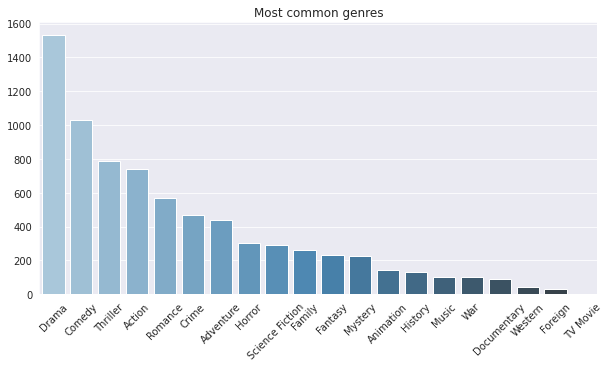

In [144]:
# The most common genres - plot
fig = plt.figure(figsize=(10, 5))
sns.barplot(y=[value[1] for value in genres_count],
            x=[value[0] for value in genres_count],
            palette="Blues_d")
plt.title('Most common genres')
plt.xticks(rotation=45)
plt.show()

#### 2.4. production_companies column <a name="heading--2-4"/>

In [145]:
for i, value in enumerate(train['production_companies'][:5]):
    print(i, value)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}


In [146]:
# checking the distribution in 'production_companies' column
train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

The most movies were created by one or to 9 production companies

In [147]:
# list of production companies for every movie
prod_companies_names_train = train['production_companies'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
prod_companies_names_test = test['production_companies'].apply(lambda x: [i['name'] for i in x] if x!={} else [])

pd.DataFrame({'title': train['title'], 
              'production_companies': prod_companies_names_train,
              'production_companies_number': prod_companies_names_train.apply(len)}).head(20)

,title,production_companies,production_companies_number
0,Hot Tub Time Machine 2,"[Paramount Pictures, United Artists, Metro-Gol...",3
1,The Princess Diaries 2: Royal Engagement,[Walt Disney Pictures],1
2,Whiplash,"[Bold Films, Blumhouse Productions, Right of W...",3
3,Kahaani,[],0
4,Marine Boy,[],0
5,Pinocchio and the Emperor of the Night,[],0
6,The Possession,"[Ghost House Pictures, North Box Productions]",2
7,Control Room,[],0
8,Muppet Treasure Island,"[Walt Disney Pictures, Jim Henson Productions,...",3
9,A Mighty Wind,[Castle Rock Entertainment],1


In [148]:
# 20 most common production companies
production_companies_count = Counter([i for j in prod_companies_names_train for i in j]).most_common()
production_companies_count[:20]

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40),
 ('Village Roadshow Pictures', 36),
 ('Regency Enterprises', 31),
 ('BBC Films', 30),
 ('Dune Entertainment', 30),
 ('Working Title Films', 30)]

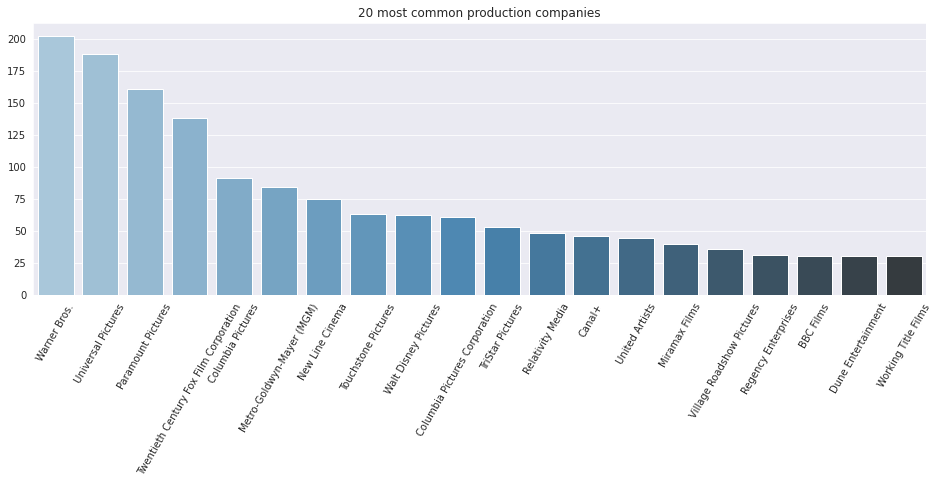

In [149]:
# 20 most common production companies - plot
fig = plt.figure(figsize=(16, 5))
sns.barplot(y=[value[1] for value in production_companies_count[:20]],
            x=[value[0] for value in production_companies_count[:20]],
            palette="Blues_d")
plt.title('20 most common production companies')
plt.xticks(rotation=60)
plt.show()

#### 2.5. production_countries column <a name="heading--2-5"/>

In [150]:
for i, value in enumerate(train['production_countries'][:5]):
    print(i, value)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [151]:
# checking the distribution in 'production_countries' column
train['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

We can see that one production coutry is the most common and later 2 countries. There are also 55 movies with no production coutry

In [152]:
# list of production countries for every movie
prod_countries_names_train = train['production_countries'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
prod_countries_names_test = test['production_countries'].apply(lambda x: [i['name'] for i in x] if x!={} else [])

pd.DataFrame({'title': train['title'], 
              'production_countries': prod_countries_names_train,
              'production_countries_number': prod_countries_names_train.apply(len)}).head(20)

,title,production_countries,production_countries_number
0,Hot Tub Time Machine 2,[United States of America],1
1,The Princess Diaries 2: Royal Engagement,[United States of America],1
2,Whiplash,[United States of America],1
3,Kahaani,[India],1
4,Marine Boy,[South Korea],1
5,Pinocchio and the Emperor of the Night,[],0
6,The Possession,"[United States of America, Canada]",2
7,Control Room,[],0
8,Muppet Treasure Island,[United States of America],1
9,A Mighty Wind,[United States of America],1


In [153]:
# 20 most common production countries
production_countries_count = Counter([i for j in prod_countries_names_train for i in j]).most_common()
production_countries_count[:20]

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23),
 ('South Korea', 22),
 ('Mexico', 19),
 ('Sweden', 18),
 ('New Zealand', 17),
 ('Netherlands', 15)]

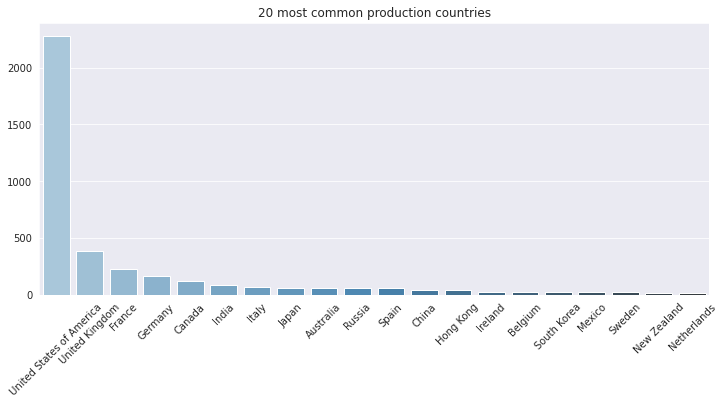

In [154]:
# 20 most common production countries - plot
fig = plt.figure(figsize=(12, 5))
sns.barplot(y=[value[1] for value in production_countries_count[:20]],
            x=[value[0] for value in production_countries_count[:20]],
            palette="Blues_d")
plt.title('20 most common production countries')
plt.xticks(rotation=45)
plt.show()

#### 2.6. spoken_languages column <a name="heading--2-6"/>

In [155]:
for i, value in enumerate(train['spoken_languages'][:5]):
    print(i, value)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [156]:
# checking the distribution in 'spoken_languages' column
train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

We can see that the most movies have one spoken language later 2. There are also 20 movies with undefined spoken language.

In [157]:
# list of spoken languages for every movie
spoken_languages_names_train = train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
spoken_languages_names_test = test['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x!={} else [])

pd.DataFrame({'title': train['title'], 
              'languages': spoken_languages_names_train,
              'languages_number': spoken_languages_names_train.apply(len)}).head(20)

,title,languages,languages_number
0,Hot Tub Time Machine 2,[English],1
1,The Princess Diaries 2: Royal Engagement,[English],1
2,Whiplash,[English],1
3,Kahaani,"[English, हिन्दी]",2
4,Marine Boy,[한국어/조선말],1
5,Pinocchio and the Emperor of the Night,[English],1
6,The Possession,[English],1
7,Control Room,"[العربية, English]",2
8,Muppet Treasure Island,[English],1
9,A Mighty Wind,[English],1


In [158]:
# 20 most common spoken languages
spoken_languages_count = Counter([i for j in spoken_languages_names_train for i in j]).most_common()
spoken_languages_count[:20]

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27),
 ('Polski', 25),
 ('Magyar', 24),
 ('Latin', 23),
 ('svenska', 22),
 ('ภาษาไทย', 22)]

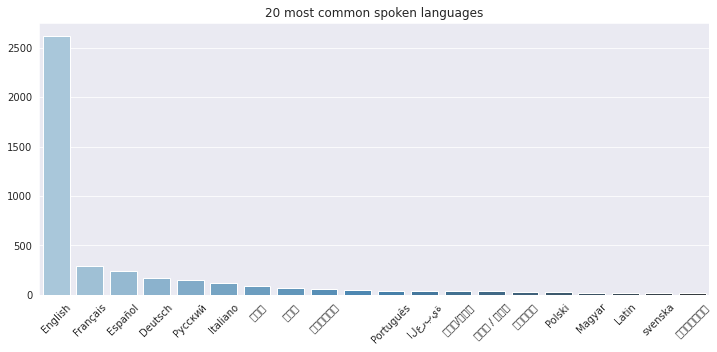

In [159]:
# 20 most common spoken languages - plot
fig = plt.figure(figsize=(12, 5))
sns.barplot(y=[value[1] for value in spoken_languages_count[:20]],
            x=[value[0] for value in spoken_languages_count[:20]],
            palette="Blues_d")
plt.title('20 most common spoken languages')
plt.xticks(rotation=45)
plt.show()

#### 2.7. Keywords column <a name="heading--2-7"/>

In [160]:
for i, value in enumerate(train['Keywords'][:5]):
    print(i, value)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [161]:
# checking the distribution in 'Keywords' column
train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts()

5      293
0      276
4      248
3      228
6      227
2      207
7      192
1      187
8      161
9      134
11     132
10     125
12     100
13      85
14      59
15      59
16      58
17      45
18      29
20      24
21      23
19      22
22      17
23      15
24      12
27      12
25       6
26       5
32       2
28       2
30       2
31       2
29       2
37       2
43       1
40       1
38       1
33       1
97       1
39       1
149      1
Name: Keywords, dtype: int64

Every movie has a very different number of Keywords. 276 movies do not have any one.

In [162]:
# list of Keywords for every movie
keywords_names_train = train['Keywords'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
keywords_names_test = test['Keywords'].apply(lambda x: [i['name'] for i in x] if x!={} else [])

pd.DataFrame({'title': train['title'], 
              'Keywords': keywords_names_train,
              'Keywords_number': keywords_names_train.apply(len)}).head(20)

,title,Keywords,Keywords_number
0,Hot Tub Time Machine 2,"[time travel, sequel, hot tub, duringcreditsst...",4
1,The Princess Diaries 2: Royal Engagement,"[coronation, duty, marriage, falling in love]",4
2,Whiplash,"[jazz, obsession, conservatory, music teacher,...",12
3,Kahaani,"[mystery, bollywood, police corruption, crime,...",7
4,Marine Boy,[],0
5,Pinocchio and the Emperor of the Night,[],0
6,The Possession,[],0
7,Control Room,"[journalism, translation, television, manipula...",7
8,Muppet Treasure Island,"[island, pirate gang, puppet, treasure hunt]",4
9,A Mighty Wind,"[mockumentary, folk singer]",2


In [164]:
# 20 most common Keywords
keywords_count = Counter([i for j in keywords_names_train for i in j]).most_common()
keywords_count[:20]

[('woman director', 175),
 ('independent film', 155),
 ('duringcreditsstinger', 134),
 ('murder', 123),
 ('based on novel', 111),
 ('violence', 87),
 ('sport', 82),
 ('biography', 77),
 ('aftercreditsstinger', 75),
 ('dystopia', 73),
 ('revenge', 73),
 ('friendship', 72),
 ('sex', 71),
 ('suspense', 67),
 ('sequel', 66),
 ('love', 64),
 ('police', 64),
 ('teenager', 61),
 ('nudity', 57),
 ('female nudity', 53)]

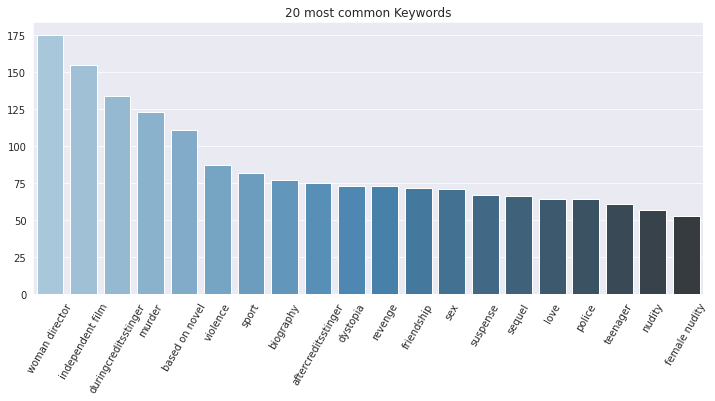

In [166]:
# 20 most common Keywords - plot
fig = plt.figure(figsize=(12, 5))
sns.barplot(y=[value[1] for value in keywords_count[:20]],
            x=[value[0] for value in keywords_count[:20]],
            palette="Blues_d")
plt.title('20 most common Keywords')
plt.xticks(rotation=60)
plt.show()

#### 2.8. Cast column <a name="heading--2-8"/>

In [172]:
train['cast'][0][0]


{'cast_id': 4,
 'character': 'Lou',
 'credit_id': '52fe4ee7c3a36847f82afae7',
 'gender': 2,
 'id': 52997,
 'name': 'Rob Corddry',
 'order': 0,
 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}

In [202]:
# checking the distribution in 'cast' column
train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts()[:30]

15    212
16    165
10    135
13    129
12    124
11    122
9     118
17    118
18    115
14    110
8     106
19    102
7      96
20     93
22     77
6      76
23     71
21     68
5      57
24     57
4      52
25     50
27     44
29     42
26     39
31     37
30     32
28     30
32     26
0      26
Name: cast, dtype: int64

In [218]:
# checking in how many movies there are undefined cast
train['cast'].apply(lambda x: len(x) if x == {} or x == [] else 'defined actors' ).value_counts()

defined actors    2974
0                   26
Name: cast, dtype: int64

In [223]:
# movies with no actors
pd.DataFrame({'title': train['title'][(train['cast'].apply(lambda x: len(x) if x != {} else 0)) == 0], 
              'cast': train['cast'][(train['cast'].apply(lambda x: len(x) if x != {} else 0)) == 0]})

,title,cast
233,Sweetgrass,[]
518,Wonder Woman,{}
680,The Day After Tomorrow,{}
773,Live Nude Girls Unite!,[]
906,The Dark Knight Rises,{}
934,John Wick: Chapter 2,{}
1136,Pokémon: Arceus and the Jewel of Life,[]
1303,Mr. Smith Goes to Washington,{}
1617,The Assassination of Richard Nixon,{}
1777,Naqoyqatsi,[]


There are 26 movies with undefinded actors.

In [175]:
# list of cast/actors for every movie
cast_names_train = train['cast'].apply(lambda x: [i['name'] for i in x] if x!={} else [])
cast_names_test = test['cast'].apply(lambda x: [i['name'] for i in x] if x!={} else [])

pd.DataFrame({'title': train['title'], 
              'actors': cast_names_train,
              'actors_number': cast_names_train.apply(len)}).head(20)

,title,actors,actors_number
0,Hot Tub Time Machine 2,"[Rob Corddry, Craig Robinson, Clark Duke, Adam...",24
1,The Princess Diaries 2: Royal Engagement,"[Anne Hathaway, Julie Andrews, H√©ctor Elizond...",20
2,Whiplash,"[Miles Teller, J.K. Simmons, Melissa Benoist, ...",51
3,Kahaani,"[Vidya Balan, Nawazuddin Siddiqui, Parambrata ...",7
4,Marine Boy,"[Kim Kang-woo, Jo Jae-hyeon, Park Si-yeon, Kim...",4
5,Pinocchio and the Emperor of the Night,"[Scott Grimes, Tom Bosley, Rickie Lee Jones, J...",4
6,The Possession,"[Jeffrey Dean Morgan, Natasha Calis, Madison D...",14
7,Control Room,"[Samir Khader, Josh Rushing, George W. Bush, H...",4
8,Muppet Treasure Island,"[Tim Curry, Kevin Bishop, Jennifer Saunders, B...",12
9,A Mighty Wind,"[Bob Balaban, Christopher Guest, John Michael ...",20


In [176]:
# 20 most common actors
cast_count = Counter([i for j in cast_names_train for i in j]).most_common()
cast_count[:20]

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21),
 ('Jason Statham', 21),
 ('Keith David', 21),
 ('John Goodman', 21),
 ('Mel Gibson', 21),
 ('Sigourney Weaver', 21)]

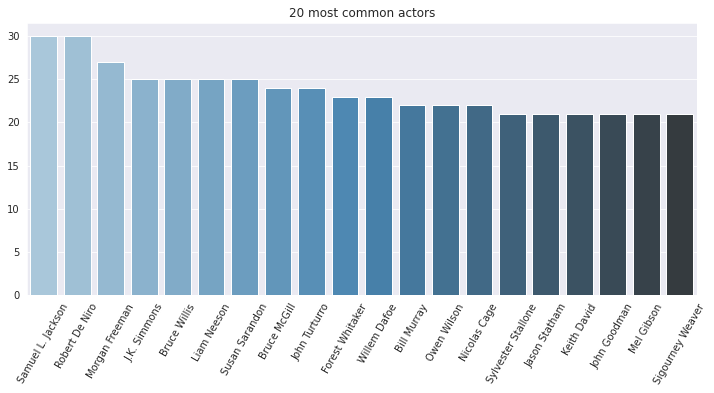

In [177]:
# 20 most common actors - plot
fig = plt.figure(figsize=(12, 5))
sns.barplot(y=[value[1] for value in cast_count[:20]],
            x=[value[0] for value in cast_count[:20]],
            palette="Blues_d")
plt.title('20 most common actors')
plt.xticks(rotation=60)
plt.show()